'engineering location features for prediction modeling'.title()

So you'd like to build a prediction model from some data, but some of the columns seem a bit . . . useless? Alternatively, the column of data might accidentally infer meaning where there shouldn't be any. Let's try this out by engineering some columns to help predict the price of a home using a small slice of the King County Housing Data set. --We will see a single variable linear prediction and get a very low R^2, or perhaps a histogram of the data is nearly uniform or double peaked, and normalizing doesn't seem possible.-- Let's explore how we can turn difficult columns into something useful instead of just throwing them away.

In [1]:
import pandas as pd

df = pd.read_csv('kc_house_data.csv')
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,10/13/2014,12/9/2014,2/25/2015,12/9/2014,2/18/2015
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,NaN,0,0,0,0
view,0,0,0,0,0


What do each of these columns mean?

In [2]:
from IPython.display import display, Markdown

with open('column_names.md', 'r') as fh:
    content = fh.read()

display(Markdown(content))

COLUMN NAMES AND DESCRIPTIONS FOR KING COUNTRY DATA SET
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


Many of these columns seem like they should have some kind of an influence on the price. In particular, the common saying "the three most important things to think about when buying are home are location, location, location" tells us we should probably care a lot about things like zipcode, latitude, and longitude. 'sqft_living15' and 'sqft_lot15' are metadata about each house in the database that someone else has already engineered for us, thanks, King Co. data scientist!

There are plenty of columns we could use, but for this tutorial, let's just focus on 'zipcode', 'lat' & 'long'

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


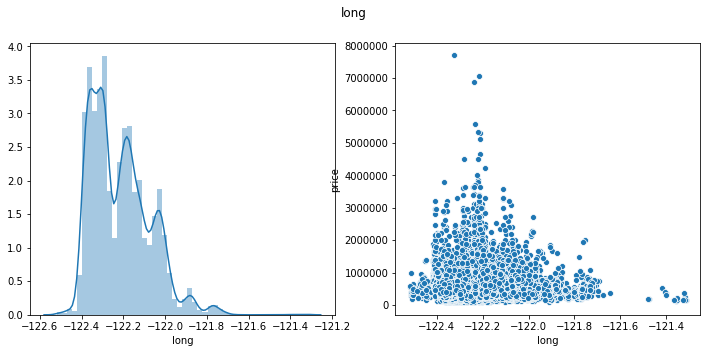

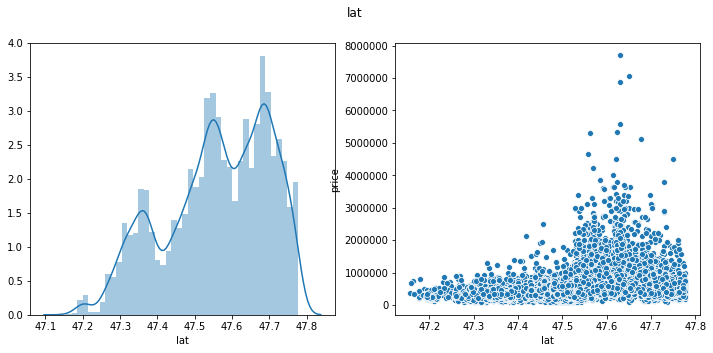

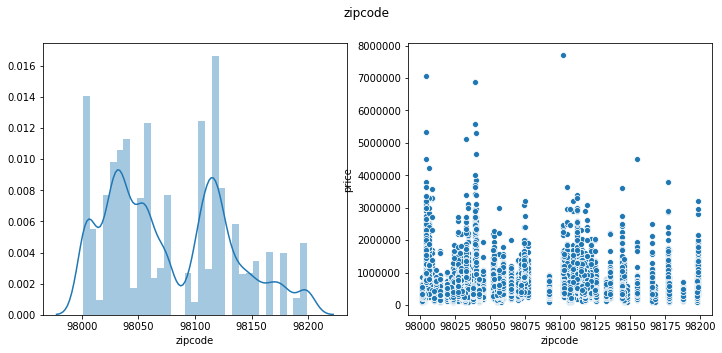

In [8]:
target = df['price']
needs_work = df[['long', 'lat', 'zipcode']]

import seaborn as sns
import matplotlib.pyplot as plt

for col in needs_work:
    x = needs_work[col]
    y = target
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.distplot(x)
    plt.subplot(1,2,2)
    
    sns.scatterplot(x, y)
    plt.suptitle(col)
    plt.tight_layout

Even though these pairs of graphs look similar, notice the y-axes on these plots are measuring different things. The histogram is simply counting how many observations of the x-value we have in the data, while the scatterplot is showing the price in USD of the house sold at the x-value. It's almost like more houses sold can also indicate a higher sale price. The Law of Supply & Demand seems alive and well in King County, WA. We'll discuss two ways of dealing with this data in regard to predicting sale price. The first method will help with the zipcodes:

A) One-Hot-Encoding  --  this is used for categorical data, and it's especially important when that data is a number ('zipcode' or 'month_as_a_number_from_1_to_12') that doesn't actually do anything other than function as a grouping mechanism. A zipcode of 98100 shouldn't be considered "lower" than zipcode 98155. The numbers themselves don't mean anything mathematically, so we need to get rid of them.

We will use OneHotEncoder from the sklearn library. [Here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is the documentation. This function can "auto" learn which columns to One-Hot-Encode, but we'll explicitly pass in which column we want to encode.

In [5]:
needs_work.head()

,long,lat,zipcode
0,-122.257,47.5112,98178
1,-122.319,47.7210,98125
2,-122.233,47.7379,98028
3,-122.393,47.5208,98136
4,-122.045,47.6168,98074


In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(needs_work.groupby(['zipcode'])['zipcode'])
#onehotlabels = enc.transform(X_2).toarray()
enc

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=<pandas.core.groupby.groupby.SeriesGroupBy object at 0x1a1e6574e0>,
       sparse=True)

Great! Now let's deal with the longitude and latitude. The problem here is that ONLY looking at one-dimensional movement on a map doesn't particularly generate accurate housing price patterns. If there are multiple wealthy neighborhoods that have lower-priced neighborhoods in between them, using just that one dimension of data won't accurately predict the value. Simply adding a second column to describe the other dimension doesn't really help either. Instead, let's think about why home values in some neighborhoods are high vs low. It could simply be the houses in those neighborhoods have a view of the mountains & water, but the only way any one home sells for a lot of money is if someone pays a lot of money for it. I know this seems simplistic, but high home values require high paying jobs, and people with high paying jobs will pay more to be conveniently close their work (especially if the home has a view of the mountains or water). This leads me to believe a "radius from high-paying job cluster" might be a much better indicator of home value instead of using the two columns of 'longitude' and 'latitude' on their own. Let's build one! In fact, if there are multiple job clusters, maybe building a single column for each "job hub" would make sense.

If you are willing to accept that we live on a round planet, we can utilize the Haversine formula, which measures 3D arc-length on the surface of a sphere.

adapted from:  https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points/4913653


In [11]:
from math import radians, cos, sin, asin, sqrt

def haversine(list_lon_lat, other=[-122.336283, 47.609395]):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees), in this case the 2nd point is in the Pike Pine Retail Core
    """
    lon1, lat1 = list_lon_lat[0], list_lon_lat[1]
    lon2, lat2 = other[0], other[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

In [14]:
needs_work.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [10]:
needs_work['dist_to_seattle'] = needs_work.apply(haversine, axis=1)
needs_work = needs_work.drop(['long', 'lat'], axis=1, inplace=True)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
